In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

In [ ]:
# ---Config ---
INPUT_DIR = Path("/kaggle/working/output_wav2vec_precomputed_5_class")
OUTPUT_DIR = Path("./output_1d_cnn_5_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

# Model & Feature Params 
MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

# Training Params
BATCH_SIZE_PER_REPLICA = 16 # per Tpu core 
EPOCHS = 150
LEARNING_RATE = 1e-4
THRESHOLD = 0.5


TRAIN_DATA_PATH = INPUT_DIR / "train_data_5_class.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data_5_class.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data_5_class.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_1d_cnn_5_class_model_tpu.keras"

In [ ]:
print("Initializing TPU Strategy")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']

print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (28187, 150, 768)


In [ ]:

print("\n--- Verifying final training set distribution after augmentation... ---")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


--- Verifying final training set distribution after augmentation... ---
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10038
WordRep          9346
dtype: int64


In [7]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding 1D CNN Model inside TPU Strategy Scope")

    def build_dnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        # Pooling Layer
        # Collapses the time dimension (150) to create a single feature vector.
        x = tf.keras.layers.GlobalAveragePooling1D()(inputs)

        # a simple DNN Classifier Head 
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_dnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


Building 1D CNN Model inside TPU Strategy Scope


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,405 (900.02 KB)

 Trainable params: 230,405 (900.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/150


I0000 00:00:1753156442.629847      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6033990254822539684
I0000 00:00:1753156443.160405     967 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11408646046472205295), session_name()
I0000 00:00:1753156445.944860     967 tpu_compile_op_common.cc:245] Compilation of 11408646046472205295 with session name  took 2.78432585s and succeeded
I0000 00:00:1753156445.961439     967 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11408646046472205295), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6033990254822539684", property.function_library_fingerprint = 12561214328509833195, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().

219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2638 - auc: 0.5368 - loss: 0.6605 - precision: 0.4375 - recall: 0.2149

I0000 00:00:1753156453.155429     932 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1088720411351060284), session_name()
I0000 00:00:1753156455.902950     932 tpu_compile_op_common.cc:245] Compilation of 1088720411351060284 with session name  took 2.747463559s and succeeded
I0000 00:00:1753156455.919916     932 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1088720411351060284), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6033990254822539684", property.function_library_fingerprint = 12561214328509833195, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,150,768,;4,5,;", property.guaranteed_constants_size = 0, embedding_part

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2636 - auc: 0.5369 - loss: 0.6604 - precision: 0.4376 - recall: 0.2140

I0000 00:00:1753156471.543284      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13422452844023870141
I0000 00:00:1753156471.902641     953 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17659958921467122724), session_name()
I0000 00:00:1753156472.711323     953 tpu_compile_op_common.cc:245] Compilation of 17659958921467122724 with session name  took 808.513597ms and succeeded
I0000 00:00:1753156472.717268     953 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17659958921467122724), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_13422452844023870141", property.function_library_fingerprint = 10668843996799633916, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap


Epoch 1: val_auc improved from -inf to 0.62284, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - accuracy: 0.2634 - auc: 0.5369 - loss: 0.6604 - precision: 0.4375 - recall: 0.2136 - val_accuracy: 0.1151 - val_auc: 0.6228 - val_loss: 0.6647 - val_precision: 1.0000 - val_recall: 0.0016
Epoch 2/150
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2462 - auc: 0.5786 - loss: 0.6455 - precision: 0.5426 - recall: 0.1023
Epoch 2: val_auc improved from 0.62284 to 0.66383, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.2461 - auc: 0.5787 - loss: 0.6455 - precision: 0.5425 - recall: 0.1024 - val_accuracy: 0.1546 - val_auc: 0.6638 - val_loss: 0.6544 - val_precision: 0.6867 - val_recall: 0.0918
Epoch 3/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2669 - auc: 0.6033 - loss: 0.6391 - precision: 0.5638 - recall: 0.152


Evaluating Model on the Test Set


I0000 00:00:1753159804.126875      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2327550081989577742
E0000 00:00:1753159804.133548      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_4_1/dense_10_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753159804.161546     974 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5262385129793627562), session_name()
I0000 00:00:1753159804.250423     974 tpu_compile_op_common.cc:245] Compilation of 5262385129793627562 with session name  took 88.829114ms and succeeded
I0000 00:00:1753159804.251156     974 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5262385129793627562), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2327550081989577742", property.function_library_fingerprint = 13053564561778365434, property.mlir_module_fingerpr

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

I0000 00:00:1753159809.085291      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2989492059375095073
I0000 00:00:1753159809.241195     885 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(544196751946658986), session_name()
I0000 00:00:1753159809.333031     885 tpu_compile_op_common.cc:245] Compilation of 544196751946658986 with session name  took 91.787796ms and succeeded
I0000 00:00:1753159809.333566     885 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(544196751946658986), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2989492059375095073", property.function_library_fingerprint = 5793921224590184853, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wr

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.66      0.35      0.46      2613
       Block       0.66      0.27      0.38      3501
    SoundRep       0.59      0.38      0.46      1891
     WordRep       0.47      0.45      0.46      1742
Interjection       0.81      0.58      0.68      3344

   micro avg       0.65      0.40      0.50     13091
   macro avg       0.64      0.41      0.49     13091
weighted avg       0.66      0.40      0.49     13091
 samples avg       0.53      0.41      0.44     13091


--- Generating plots for model training history... ---


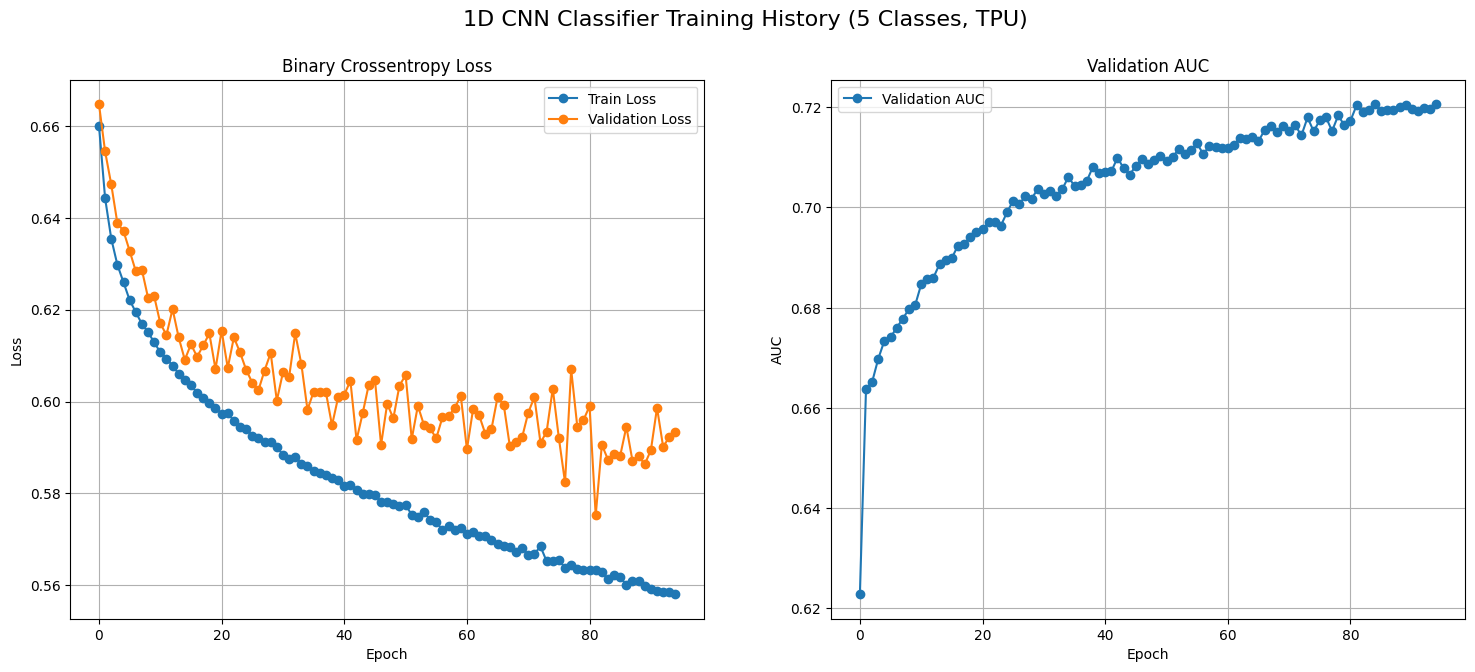


--- Pipeline complete. All outputs saved in 'output_1d_cnn_5_class_tpu' directory. ---


In [ ]:
# EVALUATION
print("\nEvaluating Model on the Test Set ")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)  # Should be DNN  
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")